In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("stl10_final.csv", header = None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27639,27640,27641,27642,27643,27644,27645,27646,27647,27648
0,146,143,110,146,143,110,146,143,110,146,...,138,127,119,147,136,122,138,128,93,1
1,129,140,73,124,133,68,138,144,84,144,...,146,128,94,151,130,91,194,164,123,0
2,179,223,114,163,203,104,165,191,103,89,...,124,149,128,114,140,117,104,131,109,1
3,14,18,29,16,21,35,14,21,41,12,...,125,80,18,123,80,18,120,80,18,0
4,147,130,91,200,189,164,127,112,89,68,...,147,131,89,145,129,93,155,138,108,0


In [4]:
X = df.iloc[:, 0:-1].to_numpy()
Y = df.iloc[:, -1].to_numpy()
X = X / 256.0

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer
import timeit

In [63]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [64]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X), torch.FloatTensor(Y))
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 27648.
        self.layer_1 = nn.Linear(27648, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        
        return x

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [11]:
def group_product(xs, ys):
    
    return sum([torch.sum(x * y) for (x, y) in zip(xs, ys)])

def normalization(v):
    # normalize a vector
    
    s = group_product(v, v)
    s = s**0.5
    s = s.cpu().item()
    v = [vi / (s + 1e-6) for vi in v]
    return v

In [12]:
class NysHessianpartial():
    
    def __init__(self, rank, rho):
        self.rank = rank
        # rho is the regularization in Nystrom sketch
        self.rho = rho
    
    def get_params_grad(self, model):
        # get parameters and differentiation
        params = []
        grads = []
        for param in model.parameters():
            if not param.requires_grad:
                continue
            params.append(param)
            grads.append(0. if param.grad is None else param.grad + 0.)
        return params, grads
    
    def update_Hessian(self, X_batch, y_batch, model, criterion, device):
        
        shift = 0.001
        # get the model parameters and gradients
        params, gradsH = self.get_params_grad(model)
        # remember the size for each group of parameters
        self.size_vec = [p.size() for p in params]
        # store random gaussian vector to a matrix
        test_matrix = []
        # Hessian vector product
        hv_matrix = []
        
        for i in range(self.rank):
            # generate gaussian random vector
            v = [torch.randn(p.size()).to(device) for p in params]
            # normalize
            v = normalization(v)
            # zero vector to store the shape
            hv_add = [torch.zeros(p.size()).to(device) for p in params]
        
            # update hessian with a subsample batch
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            model.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward(create_graph=True)
            params, gradsH = self.get_params_grad(model)
            # calculate the Hessian vector product
            hv = torch.autograd.grad(gradsH, params, grad_outputs=v,only_inputs=True,retain_graph=True)
            # add initial shift
            for i in range(len(hv)):
                hv_add[i].data = hv[i].data.add_(hv_add[i].data)    
                hv_add[i].data = hv_add[i].data.add_(v[i].data * torch.tensor(shift)) 
            
            # reshape the Hessian vector product into a long vector
            hv_ex = torch.cat([gi.view(-1) for gi in hv_add])
            # reshape the random vector into a long vector
            test_ex = torch.cat([gi.view(-1) for gi in v])
            
            # append long vectors into a large matrix
            hv_matrix.append(hv_ex)
            test_matrix.append(test_ex)
        
        # assemble the large matrix
        hv_matrix_ex = torch.column_stack(hv_matrix)
        test_matrix_ex = torch.column_stack(test_matrix)
        # calculate Omega^T * A * Omega for Cholesky
        choleskytarget = torch.mm(test_matrix_ex.t(), hv_matrix_ex)
        # perform Cholesky, if fails, do eigendecomposition
        # the new shift is the abs of smallest eigenvalue (negative) plus the original shift
        try:
            C_ex = torch.linalg.cholesky(choleskytarget)
        except:
            # eigendecomposition, eigenvalues and eigenvector matrix
            eigs, eigvectors = torch.linalg.eigh(choleskytarget)
            shift = shift + torch.abs(torch.min(eigs))
            # add shift to eigenvalues
            eigs = eigs + shift
            # put back the matrix for Cholesky by eigenvector * eigenvalues after shift * eigenvector^T 
            C_ex = torch.linalg.cholesky(torch.mm(eigvectors, torch.mm(torch.diag(eigs), eigvectors.T)))
        
        # triangular solve
        B_ex = torch.linalg.solve_triangular(C_ex, hv_matrix_ex, upper = False, left = False)
        # SVD
        U, S, V = torch.linalg.svd(B_ex, full_matrices = False)
        self.U = U
        self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))
        

In [101]:
class NysHessianOpt(Optimizer):
    r"""Implements NysHessian.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        rank (int): sketch rank
        rho: regularization
    """
    def __init__(self, params, rank = 100, rho = 0.5):
        # initialize the optimizer    
        defaults = dict(rank = rank, rho = rho)
        self.nysh = NysHessianpartial(rank, rho)
        super(NysHessianOpt, self).__init__(params, defaults)
         
    def step(self, lr):
        # one step update
        for group in self.param_groups:
            rho = group['rho']
            # compute gradient as a long vector
            g = torch.cat([p.grad.view(-1) for p in group['params']])
            # calculate the search direction by Nystrom sketch and solve
            UTg = torch.mv(self.nysh.U.t(), g) 
            g_new = torch.mv(self.nysh.U, (self.nysh.S + rho).reciprocal() * UTg) + g / rho - torch.mv(self.nysh.U, UTg) / rho            
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = g_new[ls:ls+torch.numel(p)].view(p.shape)
                ls += torch.numel(p)
                p.data.add_(-lr * gp)

In [31]:
class NysHessianOptlinesearch(Optimizer):

    def __init__(self, params, rank = 100, rho = 0.5):
        # initialize the optimizer    
        defaults = dict(rank = rank, rho = rho)
        self.nysh = NysHessianpartial(rank, rho)
        super(NysHessianOptlinesearch, self).__init__(params, defaults)
    
    def compute_direction(self):
        self.directions = []
        self.inner_product = []
        for group in self.param_groups:
            rho = group['rho']
            # compute gradient as a long vector
            g = torch.cat([p.grad.view(-1) for p in group['params']])
            # calculate the search direction by Nystrom sketch and solve
            UTg = torch.mv(self.nysh.U.t(), g) 
            g_new = torch.mv(self.nysh.U, (self.nysh.S + rho).reciprocal() * UTg) + g / rho - torch.mv(self.nysh.U, UTg) / rho            
            self.inner_product.append(torch.dot(g, g_new))
            shaped_gradient = []
            ls = 0
            for p in group['params']:
                gp = g_new[ls:ls+torch.numel(p)].view(p.shape)
                ls += torch.numel(p)
                shaped_gradient.append(gp)
            self.directions.append(shaped_gradient)
            
    def step(self, lr):
        # one step update
        group_id = 0
        for group in self.param_groups:
            direction = self.directions[group_id]
            group_id += 1
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = direction[ls]
                ls += 1
                p.data.add_(-lr * gp)
                
    def stepback(self, lr):
        # one step update_back
        group_id = 0
        for group in self.param_groups:
            direction = self.directions[group_id]
            group_id += 1
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = direction[ls]
                ls += 1
                p.data.add_(lr * gp)

In [15]:
model = BinaryClassification()
model.load_state_dict(torch.load("/data/sz533/nysnewton/initialmodel.pth"))
model.to(device)

optimizer = NysHessianOpt(model.parameters(), lr = 0.002)

In [17]:
len(optimizer.param_groups)

1

In [103]:
hes_interval = 300
# update Hessian and Nystrom sketch every couple of steps
line_search_interval = 1

model = BinaryClassification()
model.load_state_dict(torch.load("/data/sz533/nysnewton/initialmodel.pth"))
model.to(device)

optimizer = NysHessianOptlinesearch(model.parameters())

hes_iter = 0
line_search_iter = 0

alpha_max = 0.05
alpha_min = 0.0005
tau = 0.5
beta = 0.1

timelist1 = []
losslist1 = []
acclist1 = []

start_time = timeit.default_timer()

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0

    for X_batch, y_batch in train_loader:

        if hes_iter % hes_interval == 0:
            # update Hessian and sketch
            optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.compute_direction()
        
        if line_search_iter % line_search_interval == 0:
            alpha = alpha_max
            optimizer.step(torch.tensor(alpha))
            y_pred = model(X_batch)
            update_loss = criterion(y_pred, y_batch.unsqueeze(1))
            # print('loss', loss.item())
            # print('update loss', update_loss.item())
            while update_loss.item() > loss.item() + alpha * beta * optimizer.inner_product[0].item() and alpha > alpha_min:
                optimizer.stepback(torch.tensor(alpha))
                alpha = tau * alpha
                optimizer.step(torch.tensor(alpha))
                y_pred = model(X_batch)
                update_loss = criterion(y_pred, y_batch.unsqueeze(1))
        else:
            optimizer.step(torch.tensor(alpha))
            # if alpha != max_rate:
               # print('no line search', alpha, "\n")

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        hes_iter += 1
        line_search_iter += 1
        epoch_time = timeit.default_timer()

    if e % 20 == 0:
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    
    losslist1.append(epoch_loss/len(train_loader))
    timelist1.append(epoch_time - start_time)
    acclist1.append(epoch_acc/len(train_loader))

<ipython-input-12-3030989fd95c>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))


Epoch 020: | Loss: 0.26268 | Acc: 89.353
Epoch 040: | Loss: 0.05880 | Acc: 97.647
Epoch 060: | Loss: 0.27591 | Acc: 88.446
Epoch 080: | Loss: 0.15070 | Acc: 94.436
Epoch 100: | Loss: 0.18268 | Acc: 92.598


In [104]:
hes_interval = 300
# update Hessian and Nystrom sketch every couple of steps

model = BinaryClassification()
model.load_state_dict(torch.load("/data/sz533/nysnewton/initialmodel.pth"))
model.to(device)

optimizer = NysHessianOpt(model.parameters())

hes_iter = 0

timelist2 = []
losslist2 = []
acclist2 = []

lr = torch.tensor(0.003)

start_time = timeit.default_timer()

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:

        if hes_iter % hes_interval == 0:
            # update Hessian and sketch
            optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        
        optimizer.step(lr)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        hes_iter += 1
        epoch_time = timeit.default_timer()

    
    if e % 20 == 0:
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    
    losslist2.append(epoch_loss/len(train_loader))
    timelist2.append(epoch_time - start_time)
    acclist2.append(epoch_acc/len(train_loader))

<ipython-input-12-3030989fd95c>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))


Epoch 020: | Loss: 0.34757 | Acc: 86.078
Epoch 040: | Loss: 0.18647 | Acc: 93.328
Epoch 060: | Loss: 0.05034 | Acc: 99.074
Epoch 080: | Loss: 0.01274 | Acc: 99.961
Epoch 100: | Loss: 0.00533 | Acc: 100.000


In [106]:
# decreasing step size

hes_interval = 300
# update Hessian and Nystrom sketch every couple of steps

model = BinaryClassification()
model.load_state_dict(torch.load("/data/sz533/nysnewton/initialmodel.pth"))
model.to(device)

optimizer = NysHessianOpt(model.parameters())

hes_iter = 0

timelist3 = []
losslist3 = []
acclist3 = []

initial_lr = torch.tensor(0.1)

start_time = timeit.default_timer()

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:

        if hes_iter % hes_interval == 0:
            # update Hessian and sketch
            optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        
        lr = initial_lr / e
        lr = torch.max(lr, torch.tensor(0.001))
        
        optimizer.step(lr)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        hes_iter += 1
        epoch_time = timeit.default_timer()

    if e % 20 == 0:
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    
    losslist3.append(epoch_loss/len(train_loader))
    timelist3.append(epoch_time - start_time)
    acclist3.append(epoch_acc/len(train_loader))

<ipython-input-12-3030989fd95c>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))


Epoch 020: | Loss: 0.18435 | Acc: 93.074
Epoch 040: | Loss: 0.04531 | Acc: 99.132
Epoch 060: | Loss: 0.01781 | Acc: 99.887
Epoch 080: | Loss: 0.01046 | Acc: 99.990
Epoch 100: | Loss: 0.00773 | Acc: 100.000


In [48]:
import matplotlib.pyplot as plt

In [87]:
class NysHessianOptlinesearchdouble(Optimizer):

    def __init__(self, params, rank = 100, rho = 0.5):
        # initialize the optimizer    
        defaults = dict(rank = rank, rho = rho)
        self.nysh = NysHessianpartial(rank, rho)
        super(NysHessianOptlinesearchdouble, self).__init__(params, defaults)
    
    def compute_direction(self):
        self.directions = []
        self.expanddirections = []
        self.inner_product = []
        for group in self.param_groups:
            rho = group['rho']
            # compute gradient as a long vector
            g = torch.cat([p.grad.view(-1) for p in group['params']])
            # calculate the search direction by Nystrom sketch and solve
            UTg = torch.mv(self.nysh.U.t(), g) 
            g_new = torch.mv(self.nysh.U, (self.nysh.S + rho).reciprocal() * UTg) + g / rho - torch.mv(self.nysh.U, UTg) / rho            
            self.inner_product.append(torch.dot(g, g_new))
            self.expanddirections.append(g_new)
            shaped_gradient = []
            ls = 0
            for p in group['params']:
                gp = g_new[ls:ls+torch.numel(p)].view(p.shape)
                ls += torch.numel(p)
                shaped_gradient.append(gp)
            self.directions.append(shaped_gradient)       
            
    def step(self, lr):
        # one step update
        group_id = 0
        for group in self.param_groups:
            direction = self.directions[group_id]
            group_id += 1
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = direction[ls]
                ls += 1
                p.data.add_(-lr * gp)
                
    def stepback(self, lr):
        # one step update_back
        group_id = 0
        for group in self.param_groups:
            direction = self.directions[group_id]
            group_id += 1
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = direction[ls]
                ls += 1
                p.data.add_(lr * gp)

In [98]:
hes_interval = 300
# update Hessian and Nystrom sketch every couple of steps
line_search_interval = 1

model = BinaryClassification()
model.load_state_dict(torch.load("/data/sz533/nysnewton/initialmodel.pth"))
model.to(device)

optimizer = NysHessianOptlinesearchdouble(model.parameters())

hes_iter = 0
line_search_iter = 0

alpha_max = 0.05
alpha_min = 0.001
tau = 0.5
beta = 0.01

timelist4 = []
losslist4 = []
acclist4 = []

start_time = timeit.default_timer()

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0

    train_loader_iter = iter(train_loader)
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader_iter):

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch_2, y_batch_2 = next(train_loader_iter)
        X_batch_2, y_batch_2 = X_batch_2.to(device), y_batch_2.to(device)
        
        # doing with first batch
        if hes_iter % hes_interval == 0:
            # update Hessian and sketch
            optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.compute_direction()
        
        if line_search_iter % line_search_interval == 0:
                
            optimizer.zero_grad()
            y_pred_second = model(X_batch_2)
            loss_second = criterion(y_pred_second, y_batch_2.unsqueeze(1))
            loss_second.backward()
            loss_second_prev = loss_second.item()
            
            grads_second = []
            for param in model.parameters():
                if not param.requires_grad:
                    continue
                grads_second.append(0. if param.grad is None else param.grad + 0.)
            
            grads_second_expand = torch.cat([p.view(-1) for p in grads_second])
            inner_second = torch.dot(grads_second_expand, optimizer.expanddirections[0]).item()
            
            alpha = alpha_max
            optimizer.step(torch.tensor(alpha))
            y_pred_first = model(X_batch)
            loss_first = criterion(y_pred_first, y_batch.unsqueeze(1))
            y_pred_second = model(X_batch_2)
            loss_second_post = criterion(y_pred_second, y_batch_2.unsqueeze(1))
            
            while (loss_first.item() > loss.item() + alpha * beta * optimizer.inner_product[0].item() or \
            loss_second_post.item() > loss_second_prev + alpha * beta * inner_second) and \
            alpha > alpha_min:
                
                optimizer.stepback(torch.tensor(alpha))
                alpha = tau * alpha
                optimizer.step(torch.tensor(alpha))
                y_pred_first = model(X_batch)
                loss_first = criterion(y_pred_first, y_batch.unsqueeze(1))
                y_pred_second = model(X_batch_2)
                loss_second_post = criterion(y_pred_second, y_batch_2.unsqueeze(1))
            # print('alpha1', alpha)
        else:
            optimizer.step(torch.tensor(alpha))

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        hes_iter += 1
        line_search_iter += 1
        epoch_time = timeit.default_timer()
        
        # doing with second batch
        
        if hes_iter % hes_interval == 0:
            # update Hessian and sketch
            optimizer.nysh.update_Hessian(X_batch_2, y_batch_2, model, criterion, device)
        
        optimizer.zero_grad()
        y_pred_2 = model(X_batch_2)

        loss = criterion(y_pred_2, y_batch_2.unsqueeze(1))
        acc = binary_acc(y_pred_2, y_batch_2.unsqueeze(1))

        loss.backward()
        optimizer.compute_direction()
        
        if line_search_iter % line_search_interval == 0:
                
            optimizer.zero_grad()
            y_pred_second = model(X_batch)
            loss_second = criterion(y_pred_second, y_batch.unsqueeze(1))
            loss_second.backward()
            loss_second_prev = loss_second.item()
            
            grads_second = []
            for param in model.parameters():
                if not param.requires_grad:
                    continue
                grads_second.append(0. if param.grad is None else param.grad + 0.)
            
            grads_second_expand = torch.cat([p.view(-1) for p in grads_second])
            inner_second = torch.dot(grads_second_expand, optimizer.expanddirections[0]).item()
            
            alpha = alpha_max
            optimizer.step(torch.tensor(alpha))
            y_pred_first = model(X_batch_2)
            loss_first = criterion(y_pred_first, y_batch_2.unsqueeze(1))
            y_pred_second = model(X_batch)
            loss_second_post = criterion(y_pred_second, y_batch.unsqueeze(1))
            
            while (loss_first.item() > loss.item() + alpha * beta * optimizer.inner_product[0].item() or \
            loss_second_post.item() > loss_second_prev + alpha * beta * inner_second) and \
            alpha > alpha_min:
    
                optimizer.stepback(torch.tensor(alpha))
                alpha = tau * alpha
                optimizer.step(torch.tensor(alpha))
                y_pred_first = model(X_batch_2)
                loss_first = criterion(y_pred_first, y_batch_2.unsqueeze(1))
                y_pred_second = model(X_batch)
                loss_second_post = criterion(y_pred_second, y_batch.unsqueeze(1))
            # print('alpha2', alpha)
        else:
            optimizer.step(torch.tensor(alpha))


        epoch_loss += loss.item()
        epoch_acc += acc.item()
        hes_iter += 1
        line_search_iter += 1
        epoch_time = timeit.default_timer()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    losslist4.append(epoch_loss/len(train_loader))
    timelist4.append(epoch_time - start_time)
    acclist4.append(epoch_acc/len(train_loader))

<ipython-input-12-3030989fd95c>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))


Epoch 001: | Loss: 0.49016 | Acc: 81.000
Epoch 002: | Loss: 0.43427 | Acc: 83.559
Epoch 003: | Loss: 0.41157 | Acc: 84.088
Epoch 004: | Loss: 0.39773 | Acc: 84.417
Epoch 005: | Loss: 0.38728 | Acc: 84.735
Epoch 006: | Loss: 0.38201 | Acc: 84.917
Epoch 007: | Loss: 0.37309 | Acc: 85.054
Epoch 008: | Loss: 0.36870 | Acc: 85.270
Epoch 009: | Loss: 0.35767 | Acc: 85.750
Epoch 010: | Loss: 0.34943 | Acc: 86.054
Epoch 011: | Loss: 0.34154 | Acc: 86.167
Epoch 012: | Loss: 0.33275 | Acc: 86.324
Epoch 013: | Loss: 0.33229 | Acc: 86.583
Epoch 014: | Loss: 0.32925 | Acc: 86.593
Epoch 015: | Loss: 0.31700 | Acc: 87.147
Epoch 016: | Loss: 0.30888 | Acc: 87.412
Epoch 017: | Loss: 0.30252 | Acc: 87.868
Epoch 018: | Loss: 0.29698 | Acc: 88.083
Epoch 019: | Loss: 0.28739 | Acc: 88.358
Epoch 020: | Loss: 0.28367 | Acc: 88.554
Epoch 021: | Loss: 0.27439 | Acc: 89.083
Epoch 022: | Loss: 0.26995 | Acc: 89.358
Epoch 023: | Loss: 0.26520 | Acc: 89.299
Epoch 024: | Loss: 0.25765 | Acc: 89.480
Epoch 025: | Los

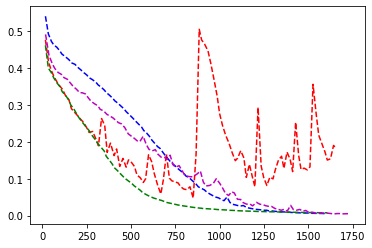

In [107]:
plt.plot(timelist1, losslist1, 'r--', timelist2, losslist2, 'b--', timelist3, losslist3, 'g--', timelist4, losslist4, 'm--')
plt.show()